# Part 1: Basic NN Movie Review Classification

In [1]:
import warnings
warnings.filterwarnings('ignore')
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Classifying movie reviews: a binary classification example
----


Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we 
will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)


The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [5]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [6]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparing the data


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, 
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in 
detail later).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [9]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

We should also vectorize our labels, which is straightforward:

In [10]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

## Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, 
activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. 

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the 
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can 
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when 
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more 
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that 
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

The intermediate layers will use `relu` as their "activation function", 
and the final layer will use a sigmoid prediction function so as to output a probability 
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 
A `relu` (rectified linear unit) is a function meant to zero-out negative values, 
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Keras implementation, very similar to earlier problems:

In [11]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you 
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" 
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will 
also monitor accuracy during training.

In [12]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and 
`accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss 
function or metric function. This former can be done by passing an optimizer class instance as the `optimizer` argument:

In [13]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

The latter can be done by passing function objects as the `loss` or `metrics` arguments:

In [14]:
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

In [15]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [16]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 5s 315us/step - loss: 0.5084 - binary_accuracy: 0.7813 - val_loss: 0.3797 - val_binary_accuracy: 0.8684
Epoch 2/20
15000/15000 [==============================] - 3s 199us/step - loss: 0.3004 - binary_accuracy: 0.9047 - val_loss: 0.3004 - val_binary_accuracy: 0.8897
Epoch 3/20
15000/15000 [==============================] - 3s 198us/step - loss: 0.2179 - binary_accuracy: 0.9285 - val_loss: 0.3085 - val_binary_accuracy: 0.8711
Epoch 4/20
15000/15000 [==============================] - 3s 191us/step - loss: 0.1750 - binary_accuracy: 0.9437 - val_loss: 0.2840 - val_binary_accuracy: 0.8832
Epoch 5/20
15000/15000 [==============================] - 3s 193us/step - loss: 0.1427 - binary_accuracy: 0.9543 - val_loss: 0.2841 - val_binary_accuracy: 0.8872
Epoch 6/20
15000/15000 [==============================] - 3s 189us/step - loss: 0.1150 - binary_accuracy: 0.9650 - val_loss: 0.3166 - val_bi

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause 
as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data 
about everything that happened during training. Let's take a look at it:

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the 
training and validation loss side by side, as well as the training and validation accuracy:

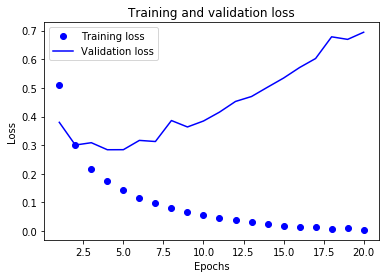

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

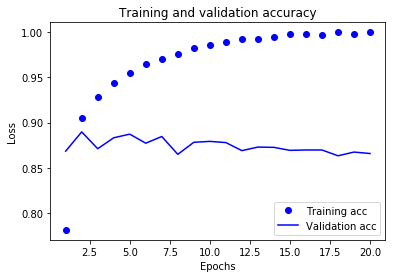

In [19]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


The dots are the training loss and accuracy, while the solid lines are the validation loss and accuracy. Note that your own results may vary 
slightly due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would 
expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that 
isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we were warning 
against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen 
before. In precise terms, what you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we 
ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after three epochs. In general, there is a range of techniques you can 
leverage to mitigate overfitting, which we will cover in the next chapter.

Let's train a new network from scratch for four epochs, then evaluate it on our test data:

In [20]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
25000/25000 [==============================] - 3s 126us/step - loss: 0.4749 - acc: 0.8217
Epoch 2/4
25000/25000 [==============================] - 3s 113us/step - loss: 0.2658 - acc: 0.9097
Epoch 3/4
25000/25000 [==============================] - 3s 114us/step - loss: 0.1982 - acc: 0.9299
Epoch 4/4
25000/25000 [==============================] - 3s 132us/step


In [21]:
results

[0.3231546032524109, 0.87348]

Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, one should be able to get close to 95%.

## Using a trained network to generate predictions on new data

After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive 
by using the `predict` method:

In [22]:
model.predict(x_test)

array([[0.1402615 ],
       [0.9997029 ],
       [0.29552552],
       ...,
       [0.0723498 ],
       [0.04342838],
       [0.4815339 ]], dtype=float32)

As you can see, the network is very confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4). 


## Further experiments


* We were using 2 hidden layers. Try to use 1 or 3 hidden layers and see how it affects validation and test accuracy.
* Try to use layers with more hidden units or less hidden units: 32 units, 64 units...
* Try to use the `mse` loss function instead of `binary_crossentropy`.
* Try to use the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

These experiments will help convince you that the architecture choices we have made are all fairly reasonable, although they can still be 
improved!

## Take away


Here's what you should take away from this example:

* There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural 
network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other encoding options too.
* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you will 
likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a `Dense` layer with 1 unit and a `sigmoid` activation, 
i.e. the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output, on a binary classification problem, the loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry 
about.
* As they get better on their training data, neural networks eventually start _overfitting_ and end up obtaining increasingly worse results on data 
never-seen-before. Make sure to always monitor performance on data that is outside of the training set.


# Part 2: One Hot Encoding of words

# One-hot encoding of words or characters


----

One-hot encoding is the most common, most basic way to turn a token into a vector. You already saw it in action in our IMDB example. It consists in associating a unique integer index to every word, then 
turning this integer index i into a binary vector of size N, the size of the vocabulary, that would be all-zeros except for the i-th 
entry, which would be 1.

Of course, one-hot encoding can be done at the character level as well. To unambiguously drive home what one-hot encoding is and how to 
implement it, here are two toy examples of one-hot encoding: one for words, the other for characters.



Word level one-hot encoding (toy example):

In [23]:
import numpy as np

# This is our initial data; one entry per "sample"
# (in this toy example, a "sample" is just a sentence, but
# it could be an entire document).
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# First, build an index of all tokens in the data.
token_index = {}
for sample in samples:
    # We simply tokenize the samples via the `split` method.
    # in real life, we would also strip punctuation and special characters
    # from the samples.
    for word in sample.split():
        if word not in token_index:
            # Assign a unique index to each unique word
            token_index[word] = len(token_index) + 1
            # Note that we don't attribute index 0 to anything.

# Next, we vectorize our samples.
# We will only consider the first `max_length` words in each sample.
max_length = 10

# This is where we store our results:
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i, j, index] = 1.

Character level one-hot encoding (toy example)

In [24]:
import string

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
characters = string.printable  # All printable ASCII characters.
token_index = dict(zip(characters, range(1, len(characters) + 1)))

max_length = 50
results = np.zeros((len(samples), max_length, max(token_index.values()) + 1))
for i, sample in enumerate(samples):
    for j, character in enumerate(sample[:max_length]):
        index = token_index.get(character)
        results[i, j, index] = 1.

Note that Keras has built-in utilities for doing one-hot encoding text at the word level or character level, starting from raw text data. 
This is what you should actually be using, as it will take care of a number of important features, such as stripping special characters 
from strings, or only taking into the top N most common words in your dataset (a common restriction to avoid dealing with very large input 
vector spaces).

Using Keras for word-level one-hot encoding:

In [25]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# We create a tokenizer, configured to only take
# into account the top-1000 most common on words
tokenizer = Tokenizer(num_words=1000)
# This builds the word index
tokenizer.fit_on_texts(samples)

# This turns strings into lists of integer indices.
sequences = tokenizer.texts_to_sequences(samples)

# You could also directly get the one-hot binary representations.
# Note that other vectorization modes than one-hot encoding are supported!
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')

# This is how you can recover the word index that was computed
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.



A variant of one-hot encoding is the so-called "one-hot hashing trick", which can be used when the number of unique tokens in your 
vocabulary is too large to handle explicitly. Instead of explicitly assigning an index to each word and keeping a reference of these 
indices in a dictionary, one may hash words into vectors of fixed size. This is typically done with a very lightweight hashing function. 
The main advantage of this method is that it does away with maintaining an explicit word index, which 
saves memory and allows online encoding of the data (starting to generate token vectors right away, before having seen all of the available 
data). The one drawback of this method is that it is susceptible to "hash collisions": two different words may end up with the same hash, 
and subsequently any machine learning model looking at these hashes won't be able to tell the difference between these words. The likelihood 
of hash collisions decreases when the dimensionality of the hashing space is much larger than the total number of unique tokens being hashed.

Word-level one-hot encoding with hashing trick (toy example):

In [26]:
samples = ['The cat sat on the mat.', 'The dog ate my homework.']

# We will store our words as vectors of size 1000.
# Note that if you have close to 1000 words (or more)
# you will start seeing many hash collisions, which
# will decrease the accuracy of this encoding method.
dimensionality = 1000
max_length = 10

results = np.zeros((len(samples), max_length, dimensionality))
for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        # Hash the word into a "random" integer index
        # that is between 0 and 1000
        index = abs(hash(word)) % dimensionality
        results[i, j, index] = 1.

# Part 3: Skip gram Word2vec in Keras

# Skip-gram word2vec in Keras

This notebook contains the Keras implementation of word2vec algorithm using skip-gram architecture. The goal is to learn about word embedding  for use in natural language processing problems like text classification, translation, NER, etc.

## Resources

To learn further about word2vec.

* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 


To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.


Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



<img src="../images/word2vec-1.png" width="100%" />

<img src="../images/word2vec-2.png" width="100%" />

<img src="../images/word2vec-3.png" width="100%" />

<img src="../images/word2vec-5.png" width="100%" />

<img src="../images/word2vec-6.png" width="100%" />
<img src="../images/word2vec-7.png" width="100%" />
<img src="../images/word2vec-8.png" width="100%" />
<img src="../images/word2vec-9.png" width="100%" />
<img src="../images/word2vec-10.png" width="100%" />
<img src="../images/word2vec-11.png" width="100%" />
<img src="../images/word2vec-13.png" width="100%" />
<img src="../images/word2vec-12.png" width="100%" />


In [27]:
# standard
import urllib
import collections
import os
import zipfile
from tempfile import gettempdir
import json

# 3rd party
import numpy as np
import tensorflow as tf
import pandas as pd

#keras
from keras.models import Model
from keras.layers import Input, Dense, Reshape, merge
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence

### Download dataset

* The dataset we will be using for this excercise is a dump of curated articles from Wikipedia by Matt Mahoney

In [28]:
# # Step 1: Download the data.
# url = 'http://mattmahoney.net/dc/'

# # pylint: disable=redefined-outer-name
# def maybe_download(filename, expected_bytes):
#     """Download a file if not present, and make sure it's the right size."""
#     local_filename = os.path.join(gettempdir(), filename)
#     if not os.path.exists(local_filename):
#         local_filename, _ = urllib.request.urlretrieve(url + filename,
#                                                        local_filename)
#     statinfo = os.stat(local_filename)
#     if statinfo.st_size == expected_bytes:
#         print('Found and verified', filename)
#     else:
#         print(statinfo.st_size)
#         raise Exception('Failed to verify ' + local_filename +
#                         '. Can you get to it with a browser?')
#     return local_filename

# filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [29]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words."""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(filename)
print('Numbder of words', len(vocabulary))
print('Numbder of unique words', len(set(vocabulary)))

Numbder of words 17005207
Numbder of unique words 253854


### Build the dictionary

* Create a dictionary with a vocabulary size of 10k

* Replace rare words with UNK token

#### Variables:

    * data - list of codes (integers from 0 to vocabulary_size-1).
    * count - map of words(strings) to count of occurrences
    * dictionary - map of words(strings) to their codes(integers)
    * reverse_dictionary - maps codes(integers) to words(strings)
    

In [30]:
vocabulary_size = 10000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
del vocabulary  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0
with open('dictionary.json', 'w') as f:
    json.dump(dictionary, f, indent=2)

Most common words (+UNK) [['UNK', 1737307], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### Create input data

#### Few Concepts

##### Context of the word

The context of the word is the key measure of meaning that is utilized in Word2Vec.  The context of the word “sat” in the sentence “the cat sat on the mat” is (“the”, “cat”, “on”, “the”, “mat”).  In other words, it is the words which commonly occur around the target word “sat”. Words which have similar contexts share meaning under Word2Vec, and their reduced vector representations will be similar.  In the skip-gram model version of Word2Vec (more on this later), the goal is to take a target word i.e. “sat” and predict the surrounding context words.  This involves an iterative learning process.

##### Negative Sampling

The problem with using a full softmax output layer is that it is very computationally expensive. During bacpropagation, large numder of weights that need to be updated in any gradient based training of the output layer.  This gets seriously time-consuming and inefficient.

The solution to this problem is **negative sampling**, which is described in the original Word2Vec paper by Mikolov et al.  It works by reinforcing the strength of weights which link a target word to its context words, but rather than reducing the value of all those weights which aren’t in the context, it simply samples a small number of them – these are called the “negative samples”.

##### Creating the train data

To train our data set using negative sampling and the skip-gram method, we need to create data samples for both valid context words and for negative samples. This involves scanning through the data set and picking target words, then randomly selecting context words from within the window of words around the target word (i.e. if the target word is “on” from “the cat sat on the mat”, with a window size of 2 the words “cat”, “sat”, “the”, “mat” could all be randomly selected as valid context words).  It also involves randomly selecting negative samples outside of the selected target word context. Finally, we also need to set a label of 1 or 0, depending on whether the supplied context word is a true context word or a negative sample.

The Keras skipgrams function does exactly what we want of it – it returns the word couples in the form of (target, context) and also gives a matching label of 1 or 0 depending on whether context is a true context word or a negative sample. By default, it returns randomly shuffled couples and labels.

#### Variables

    * couples - list of tuples in the form of (target word, context of word)
    * labels - label indicating whether the corresponding couple has true context word or a negative sample

In [31]:
window_size = 3

sampling_table = sequence.make_sampling_table(vocabulary_size)
couples, labels = skipgrams(data, vocabulary_size, window_size=window_size, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print(couples[:10], labels[:10])

[[426, 147], [728, 1650], [4596, 7677], [7264, 8653], [98, 23], [8401, 1083], [1243, 107], [21, 3091], [105, 1754], [9637, 512]] [1, 0, 0, 0, 1, 0, 1, 0, 0, 0]


#### Model Architecture

To train the embedding layer using negative samples, we can construct our network in a way that the output layer is a multi-class softmax layer, we can change it into a simple binary classifier.  For words that are in the context of the target word, we want our network to output a 1, and for our negative samples, we want our network to output a 0. Therefore, the output layer of our Word2Vec Keras network is simply a single node with a sigmoid activation function.

We also need a way of ensuring that, as the network trains, words which are similar end up having similar embedding vectors.  Therefore, we want to ensure that the trained network will always output a 1 when it is supplied words which are in the same context, but 0 when it is supplied words which are never in the same context. Therefore, we need a vector similarity score supplied to the output sigmoid layer – with similar vectors outputting a high score and un-similar vectors outputting a low score.  The most typical similarity measure used between two vectors is the cosine similarity score:

So with all in perspective, our model contains the following layers

* An (integer) input of a target word and a real or negative context word
* An embedding layer lookup (i.e. looking up the integer index of the word in the embedding matrix to get the word vector)
* The application of a dot product operation
* The output sigmoid layer


Let’s go through this architecture more carefully.  First, each of the words in our vocabulary is assigned an integer index between 0 and the size of our vocabulary (in this case, 10,000).  We pass two words into the network, one the target word and the other either a word from the surrounding context or a negative sample.  We “look up” these indexes as the rows of our embedding layer (10,000 x 128 weight tensor) to retrieve our 128 length word vectors.  We then perform a dot product operation between these vectors to get the similarity.  Finally, we output the similarity to a sigmoid layer to give us a 1 or 0 indicator which we can match with the label given to the Context word (1 for a true context word, 0 for a negative sample).

The back-propagation of our errors will work to update the embedding layer to ensure that words which are truly similar to each other (i.e. share contexts) have vectors such that they return high similarity scores.

In [32]:
vector_dim = 128
epochs = 10001 #100001

valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# create some input variables
input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocabulary_size, vector_dim, input_length=1, name='embedding')
target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

# setup a cosine similarity operation which will be output in a secondary model
similarity = merge([target, context], mode='cos', dot_axes=0)

# now perform the dot product operation to get a similarity measure
dot_product = merge([target, context], mode='dot', dot_axes=1)
dot_product = Reshape((1,))(dot_product)
# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)
# create the primary training model
model = Model(input=[input_target, input_context], output=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

# create a secondary validation model to run our similarity checks during training
validation_model = Model(input=[input_target, input_context], output=similarity)

TypeError: 'module' object is not callable

### Training

We train the model for 100k epochs and after every 10k epoch, print the words closer to the words in validation set

#### Functions

    * get_sim() - Function to retrive topk words that are closer to a given word based on embeddings

In [33]:
def get_sim():
    for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        sim = _get_sim(valid_examples[i])
        nearest = (-sim).argsort()[1:top_k + 1]
        log_str = 'Nearest to %s:' % valid_word
        for k in range(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log_str = '%s %s,' % (log_str, close_word)
        print(log_str)

def _get_sim(valid_word_idx):
    sim = np.zeros((vocabulary_size,))
    in_arr1 = np.zeros((1,))
    in_arr2 = np.zeros((1,))
    in_arr1[0,] = valid_word_idx
    for i in range(vocabulary_size):
        in_arr2[0,] = i
        out = validation_model.predict_on_batch([in_arr1, in_arr2])
        sim[i] = out
    return sim

in_word_target = np.zeros((1,))
in_word_context = np.zeros((1,))
in_labels = np.zeros((1,))

for cnt in range(epochs):
    idx = np.random.randint(0, len(labels)-1)
    in_word_target[0,] = word_target[idx]
    in_word_context[0,] = word_context[idx]
    in_labels[0,] = labels[idx]
    loss = model.train_on_batch([in_word_target, in_word_context], in_labels)
    
    if cnt % 100 == 0:
        print("Iteration {}, loss={}".format(cnt, loss))
    if cnt % 10000 == 0:
        get_sim()
        
model.save('word2vec')

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 2 arrays: [array([[70.]]), array([[3413.]])]...

### Embeddings

* Embeddings can be created by extracting the weight of the emnbedding layer in the trained model

In [34]:
embs = model.get_weights()[0]

### Interactive Data Visualization

Using T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project high dimesional vectors into smaller dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [35]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
plot_w2v = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(embs)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = [reverse_dictionary[i] for i in range(embs.shape[0])]

# plotting. the corresponding word appears when you hover on the data point.
plot_w2v.scatter(x='x', y='y', source=tsne_df)
hover = plot_w2v.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_w2v)

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.034s...
[t-SNE] Computed neighbors for 10000 samples in 2.430s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.020068
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.976402
[t-SNE] KL divergence after 1000 iterations: 3.010122


# Part 4: Movie review classification using word2vec

# Using word embeddings


---


We learned that a popular and powerful way to associate a vector with a word is the use of dense "word vectors", also called "word embeddings". 
While the vectors obtained through one-hot encoding are binary, sparse (mostly made of zeros) and very high-dimensional (same dimensionality as the 
number of words in the vocabulary), "word embeddings" are low-dimensional floating point vectors 
(i.e. "dense" vectors, as opposed to sparse vectors). 
Unlike word vectors obtained via one-hot encoding, word embeddings are learned from data. 
It is common to see word embeddings that are 256-dimensional, 512-dimensional, or 1024-dimensional when dealing with very large vocabularies. 
On the other hand, one-hot encoding words generally leads to vectors that are 20,000-dimensional or higher (capturing a vocabulary of 20,000 
token in this case). So, word embeddings pack more information into far fewer dimensions. 

![word embeddings vs. one hot encoding](https://s3.amazonaws.com/book.keras.io/img/ch6/word_embeddings.png)

There are two ways to obtain word embeddings:

* Learn word embeddings jointly with the main task you care about (e.g. document classification or sentiment prediction). 
In this setup, you would start with random word vectors, then learn your word vectors in the same way that you learn the weights of a neural network.
* Load into your model word embeddings that were pre-computed using a different machine learning task than the one you are trying to solve. 
These are called "pre-trained word embeddings". 

Let's take a look at both.`

## Learning word embeddings with the `Embedding` layer


The simplest way to associate a dense vector to a word would be to pick the vector at random. The problem with this approach is that the 
resulting embedding space would have no structure: for instance, the words "accurate" and "exact" may end up with completely different 
embeddings, even though they are interchangeable in most sentences. It would be very difficult for a deep neural network to make sense of 
such a noisy, unstructured embedding space. 

To get a bit more abstract: the geometric relationships between word vectors should reflect the semantic relationships between these words. 
Word embeddings are meant to map human language into a geometric space. For instance, in a reasonable embedding space, we would expect 
synonyms to be embedded into similar word vectors, and in general we would expect the geometric distance (e.g. L2 distance) between any two 
word vectors to relate to the semantic distance of the associated words (words meaning very different things would be embedded to points 
far away from each other, while related words would be closer). Even beyond mere distance, we may want specific __directions__ in the 
embedding space to be meaningful. 

[...]


In real-world word embedding spaces, common examples of meaningful geometric transformations are "gender vectors" and "plural vector". For 
instance, by adding a "female vector" to the vector "king", one obtain the vector "queen". By adding a "plural vector", one obtain "kings". 
Word embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Is there some "ideal" word embedding space that would perfectly map human language and could be used for any natural language processing 
task? Possibly, but in any case, we have yet to compute anything of the sort. Also, there isn't such a thing as "human language", there are 
many different languages and they are not isomorphic, as a language is the reflection of a specific culture and a specific context. But more 
pragmatically, what makes a good word embedding space depends heavily on your task: the perfect word embedding space for an 
English-language movie review sentiment analysis model may look very different from the perfect embedding space for an English-language 
legal document classification model, because the importance of certain semantic relationships varies from task to task.

It is thus reasonable to __learn__ a new embedding space with every new task. Thankfully, backpropagation makes this really easy, and Keras makes it 
even easier. It's just about learning the weights of a layer: the `Embedding` layer.

In [28]:
from keras.layers import Embedding

# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 64.
embedding_layer = Embedding(1000, 64)


The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes 
as input integers, it looks up these integers into an internal dictionary, and it returns the associated vectors. It's effectively a dictionary lookup.


The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of 
integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have 
shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must 
have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated.


When you instantiate an `Embedding` layer, its weights (its internal dictionary of token vectors) are initially random, just like with any 
other layer. During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the 
downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for 
the specific problem you were training your model for.

Let's apply this idea to the IMDB movie review sentiment prediction task that you are already familiar with. Let's quickly prepare 
the data. We will restrict the movie reviews to the top 10,000 most common words (like we did the first time we worked with this dataset), 
and cut the reviews after only 20 words. Our network will simply learn 8-dimensional embeddings for each of the 10,000 words, turn the 
input integer sequences (2D integer tensor) into embedded sequences (3D float tensor), flatten the tensor to 2D, and train a single `Dense` 
layer on top for classification.

In [29]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000

# Cut texts after this number of words 
# (among top max_features most common words)
maxlen = 20

# Load the data as lists of integers.
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# This turns our lists of integers
# into a 2D integer tensor of shape `(samples, maxlen)`
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

## Network architecture

<img src="../images/word2vec-sim.png" width="70%" />

In [30]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=maxlen))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 175us/step - loss: 0.6759 - acc: 0.6050 - val_loss: 0.6398 - val_acc: 0.6814
Epoch 2/10
20000/20000 [==============================] - 3s 156us/step - loss: 0.5657 - acc: 0.7427 - val_loss: 0.5467 - val_acc: 0.7206
Epoch 3/10
20000/20000 [==============================] - 3s 157us/step - los

We get to a validation accuracy of ~76%, which is pretty good considering that we only look at the first 20 words in every review. But 
note that merely flattening the embedded sequences and training a single `Dense` layer on top leads to a model that treats each word in the 
input sequence separately, without considering inter-word relationships and structure sentence (e.g. it would likely treat both _"this movie 
is heck"_ and _"this movie is one heck of a ride"_ as being negative "reviews"). 

It would be much better to add recurrent layers or 1D convolutional 
layers on top of the embedded sequences to learn features that take into account each sequence as a whole. That's what we will focus on in 
the next few sections.

## Using pre-trained word embeddings


Sometimes, you have so little training data available that could never use your data alone to learn an appropriate task-specific embedding 
of your vocabulary. What to do then?

Instead of learning word embeddings jointly with the problem you want to solve, you could be loading embedding vectors from a pre-computed 
embedding space known to be highly structured and to exhibit useful properties -- that captures generic aspects of language structure. The 
rationale behind using pre-trained word embeddings in natural language processing is very much the same as for using pre-trained convnets 
in image classification: we don't have enough data available to learn truly powerful features on our own, but we expect the features that 
we need to be fairly generic, i.e. common visual features or semantic features. In this case it makes sense to reuse features learned on a 
different problem.

Such word embeddings are generally computed using word occurrence statistics (observations about what words co-occur in sentences or 
documents), using a variety of techniques, some involving neural networks, others not. The idea of a dense, low-dimensional embedding space 
for words, computed in an unsupervised way, was initially explored by Bengio et al. in the early 2000s, but it only started really taking 
off in research and industry applications after the release of one of the most famous and successful word embedding scheme: the Word2Vec 
algorithm, developed by Mikolov at Google in 2013. Word2Vec dimensions capture specific semantic properties, e.g. gender.

There are various pre-computed databases of word embeddings that can download and start using in a Keras `Embedding` layer. Word2Vec is one 
of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word 
Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. Its developers have made 
available pre-computed embeddings for millions of English tokens, obtained from Wikipedia data or from Common Crawl data.

Let's take a look at how you can get started using GloVe embeddings in a Keras model. The same method will of course be valid for Word2Vec 
embeddings or any other word embedding database that you can download. We will also use this example to refresh the text tokenization 
techniques we introduced a few paragraphs ago: we will start from raw text, and work our way up.

## Putting it all together: from raw text to word embeddings


We will be using a model similar to the one we just went over -- embedding sentences in sequences of vectors, flattening them and training a 
`Dense` layer on top. But we will do it using pre-trained word embeddings, and instead of using the pre-tokenized IMDB data packaged in 
Keras, we will start from scratch, by downloading the original text data.

### Download the IMDB data as raw text


First, head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just 
Google "IMDB dataset"). Uncompress it.

Now let's collect the individual training reviews into a list of strings, one string per review, and let's also collect the review labels 
(positive / negative) into a `labels` list:

In [31]:
import os
os.getcwd()

'/home/bick23/Desktop/deep_learning_bootcamp/04_rnn/notebook'

In [33]:
import os

# imdb_dir = '/home/bick23/Desktop/deep_learning_bootcamp/data/data_text_processing/aclImdb'
imdb_dir = '/home/data/data_text_processing/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### Tokenize the data


Let's vectorize the texts we collected, and prepare a training and validation split.
We will merely be using the concepts we introduced earlier in this section.

Because pre-trained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, 
task-specific embeddings are likely to outperform them), we will add the following twist: we restrict the training data to its first 200 
samples. So we will be learning to classify movie reviews after looking at just 200 examples...


In [37]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100  # We will cut reviews after 100 words
training_samples = 200  # We will be training on 200 samples
validation_samples = 10000  # We will be validating on 10000 samples
max_words = 10000  # We will only consider the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where sample are ordered (all negative first, then all positive).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


### Download the GloVe word embeddings


Head to `https://nlp.stanford.edu/projects/glove/` (where you can learn more about the GloVe algorithm), and download the pre-computed 
embeddings from 2014 English Wikipedia. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

### Pre-process the embeddings


Let's parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number 
vectors).

In [35]:
# glove_dir = '/home/bick23/Desktop/deep_learning_bootcamp/data/data_text_processing/'
glove_dir = '/home/data/data_text_processing'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.



Now let's build an embedding matrix that we will be able to load into an `Embedding` layer. It must be a matrix of shape `(max_words, 
embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [38]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### Define a model

We will be using the same model architecture as before:

In [39]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### Load the GloVe embeddings in the model


The `Embedding` layer has a single weight matrix: a 2D float matrix where each entry `i` is the word vector meant to be associated with 
index `i`. Simple enough. Let's just load the GloVe matrix we prepared into our `Embedding` layer, the first layer in our model:

In [45]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False


Additionally, we freeze the embedding layer (we set its `trainable` attribute to `False`), following the same rationale as what you are 
already familiar with in the context of pre-trained convnet features: when parts of a model are pre-trained (like our `Embedding` layer), 
and parts are randomly initialized (like our classifier), the pre-trained parts should not be updated during training to avoid forgetting 
what they already know. The large gradient updated triggered by the randomly initialized layers would be very disruptive to the already 
learned features.

### Train and evaluate

Let's compile our model and train it:

In [46]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 1.5906 - acc: 0.5250 - val_loss: 0.6906 - val_acc: 0.5257
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.5604 - acc: 0.7300 - val_loss: 0.7278 - val_acc: 0.5120
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3920 - acc: 0.8600 - val_loss: 0.6835 - val_acc: 0.5669
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3568 - acc: 0.8350 - val_loss: 0.8339 - val_acc: 0.5151
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 0.3011 - acc: 0.8650 - val_loss: 0.6787 - val_acc: 0.5845
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1717 - acc: 0.9900 - val_loss: 0.7116 - val_acc: 0.5753
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 0.1225 - acc: 0.9900 - val_loss: 1.6686 - val_acc: 0.4937
Epoch 8/10
200/200 [========

Let's plot its performance over time:

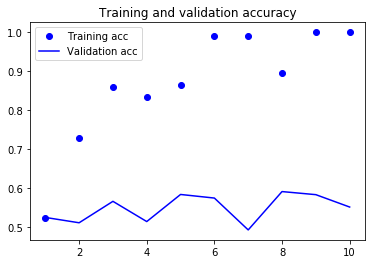

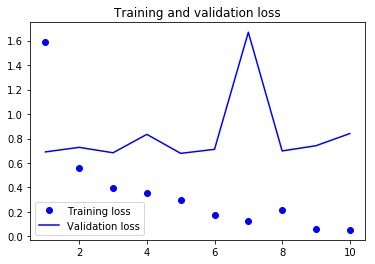

In [47]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


The model quickly starts overfitting, unsurprisingly given the small number of training samples. Validation accuracy has high variance for 
the same reason, but seems to reach high 50s.

Note that your mileage may vary: since we have so few training samples, performance is heavily dependent on which exact 200 samples we 
picked, and we picked them at random. If it worked really poorly for you, try picking a different random set of 200 samples, just for the 
sake of the exercise (in real life you don't get to pick your training data).

We can also try to train the same model without loading the pre-trained word embeddings and without freezing the embedding layer. In that 
case, we would be learning a task-specific embedding of our input tokens, which is generally more powerful than pre-trained word embeddings 
when lots of data is available. However, in our case, we have only 200 training samples. Let's try it:

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.6915 - acc: 0.5200 - val_loss: 0.6957 - val_acc: 0.5141
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 0.4840 - a

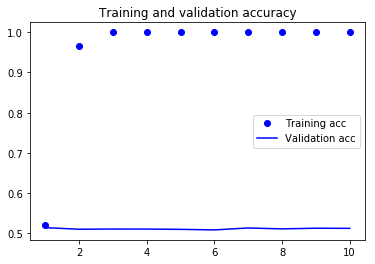

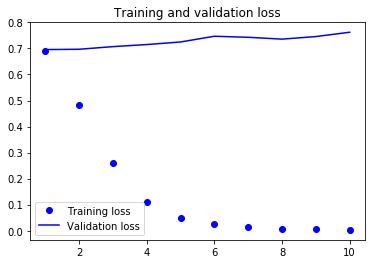

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Validation accuracy stalls in the low 50s. So in our case, pre-trained word embeddings does outperform jointly learned embeddings. If you 
increase the number of training samples, this will quickly stop being the case -- try it as an exercise.

Finally, let's evaluate the model on the test data. First, we will need to tokenize the test data:

In [50]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

And let's load and evaluate the first model:

In [51]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 1s 38us/step


[0.860870813293457, 0.55]

We get an appalling test accuracy of 54%. Working with just a handful of training samples is hard!

# Understanding recurrent neural networks

<img src="../images/rnn-1.png" width="100%" />
<img src="../images/rnn-2.png" width="100%" />
<img src="../images/rnn-3.png" width="100%" />
<img src="../images/rnn-4.png" width="100%" />
<img src="../images/rnn-5.png" width="100%" />

# Understanding encoder-decoder frameworks

<img src="../images/bot-1.png" width="100%" />
<img src="../images/bot-2.png" width="100%" />
<img src="../images/bot-3.png" width="100%" />
<img src="../images/bot-4.png" width="100%" />
<img src="../images/bot-5.png" width="100%" />
<img src="../images/bot-6.png" width="100%" />
<img src="../images/bot-7.png" width="100%" />
<img src="../images/bot-8.png" width="100%" />
<img src="../images/bot-9.png" width="100%" />
<img src="../images/bot-10.png" width="100%" />

In [52]:
from keras.layers import SimpleRNN

`SimpleRNN` processes batches of sequences.This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

`SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [53]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [54]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [55]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [56]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [57]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 33s 2ms/step - loss: 0.6464 - acc: 0.6085 - val_loss: 0.5118 - val_acc: 0.7662
Epoch 2/10
20000/20000 [==============================] - 34s 2ms/step - loss: 0.4366 - acc: 0.8091 - val_loss: 0.4766 - val_acc: 0.7770
Epoch 3/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.3165 - acc: 0.8713 - val_loss: 0.3828 - val_acc: 0.8352
Epoch 4/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.2442 - acc: 0.9050 - val_loss: 0.3474 - val_acc: 0.8666
Epoch 5/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.1786 - acc: 0.9351 - val_loss: 0.4333 - val_acc: 0.8212
Epoch 6/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.1286 - acc: 0.9550 - val_loss: 0.3847 - val_acc: 0.8574
Epoch 7/10
20000/20000 [==============================] - 37s 2ms/step - loss: 0.0809 - acc: 0.9733 - val_loss: 0.4931 - val_acc:

Let's display the training and validation loss and accuracy:

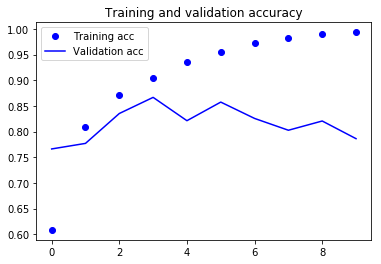

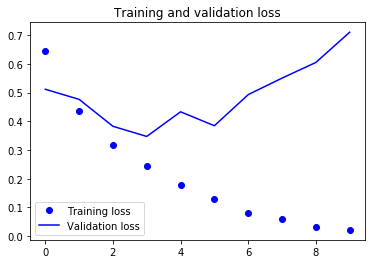

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

## RNN Vs LSTM

<img src="../images/vanishing-gradient-1.png" width="100%" />
<img src="../images/vanishing-gradient-2.png" width="100%" />
<img src="../images/vanishing-gradient-3.png" width="100%" />
<img src="../images/vanishing-gradient-4.png" width="100%" />
<img src="../images/vanishing-gradient-5.png" width="100%" />
<img src="../images/vanishing-gradient-6.png" width="100%" />
<img src="../images/vanishing-gradient-7.png" width="100%" />
<img src="../images/vanishing-gradient-8.png" width="100%" />
<img src="../images/vanishing-gradient-9.png" width="100%" />
<img src="../images/vanishing-gradient-10.png" width="100%" />
<img src="../images/vanishing-gradient-11.png" width="100%" />
<img src="../images/vanishing-gradient-12.png" width="100%" />
<img src="../images/vanishing-gradient-13.png" width="100%" />

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [59]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 159s 8ms/step - loss: 0.5091 - acc: 0.7616 - val_loss: 0.4493 - val_acc: 0.7948
Epoch 2/10
20000/20000 [==============================] - 163s 8ms/step - loss: 0.2912 - acc: 0.8860 - val_loss: 0.3069 - val_acc: 0.8766
Epoch 3/10
20000/20000 [==============================] - 155s 8ms/step - loss: 0.2329 - acc: 0.9109 - val_loss: 0.2992 - val_acc: 0.8828
Epoch 4/10
20000/20000 [==============================] - 157s 8ms/step - loss: 0.1936 - acc: 0.9286 - val_loss: 0.2811 - val_acc: 0.8896
Epoch 5/10
20000/20000 [==============================] - 153s 8ms/step - loss: 0.1731 - acc: 0.9354 - val_loss: 0.3055 - val_acc: 0.8858
Epoch 6/10
20000/20000 [==============================] - 154s 8ms/step - loss: 0.1548 - acc: 0.9440 - val_loss: 0.3976 - val_acc: 0.8714
Epoch 7/10
20000/20000 [==============================] - 152s 8ms/step - loss: 0.1385 - acc: 0.9510 - val_loss: 0.4972 - v

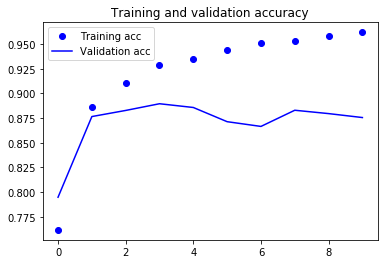

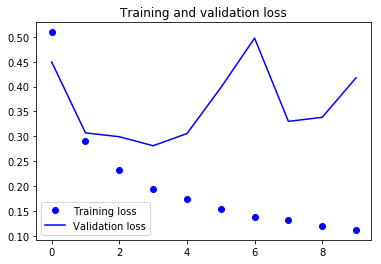

In [60]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Combining CNN - RNN for image captioning

<img src="../images/image-captioning.png" width="100%" />
<img src="../images/image-captioning-2.png" width="100%" />
<img src="../images/image-captioning-3.png" width="100%" />
<img src="../images/image-captioning-4.png" width="100%" />

# Part 6: Advanced Neural Networks

# Advanced usage of recurrent neural networks

---

In this section, we will review three advanced techniques for improving the performance and generalization power of recurrent neural 
networks. By the end of the section, you will know most of what there is to know about using recurrent networks with Keras. We will 
demonstrate all three concepts on a weather forecasting problem, where we have access to a timeseries of data points coming from sensors 
installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 
24 hours after the last data point collected. This is a fairly challenging problem that exemplifies many common difficulties encountered 
when working with timeseries.

We will cover the following techniques:

* *Recurrent dropout*, a specific, built-in way to use dropout to fight overfitting in recurrent layers.
* *Stacking recurrent layers*, to increase the representational power of the network (at the cost of higher computational loads).
* *Bidirectional recurrent layers*, which presents the same information to a recurrent network in different ways, increasing accuracy and 
mitigating forgetting issues.

## A temperature forecasting problem

Until now, the only sequence data we have covered has been text data, for instance the IMDB dataset. But sequence 
data is found in many more problems than just language processing. In all of our examples in this section, we will be playing with a weather 
timeseries dataset recorded at the Weather Station at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

In this dataset, fourteen different quantities (such air temperature, atmospheric pressure, humidity, wind direction, etc.) are recorded 
every ten minutes, over several years. The original data goes back to 2003, but we limit ourselves to data from 2009-2016. This dataset is 
perfect for learning to work with numerical timeseries. We will use it to build a model that takes as input some data from the recent past (a 
few days worth of data points) and predicts the air temperature 24 hours in the future.

Let's take a look at the data:

In [40]:
import os

# data_dir = '../../data/data_text_processing'
data_dir = '../../../data/data_text_processing'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Let's convert all of these 420,551 lines of data into a Numpy array:

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

For instance, here is the plot of temperature (in degrees Celsius) over time:

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()


On this plot, you can clearly see the yearly periodicity of temperature.

Here is a more narrow plot of the first ten days of temperature data (since the data is recorded every ten minutes, we get 144 data points 
per day):

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()


On this plot, you can see daily periodicity, especially evident for the last 4 days. We can also note that this ten-days period must be 
coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few month of past data, the problem would be easy, due to the 
reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a lot more chaotic. So is 
this timeseries predictable at a daily scale? Let's find out.

## Preparing the data


The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) 
and sampled every `steps` timesteps, can we predict the temperature in `delay` timesteps?

We will use the following parameter values:

* `lookback = 720`, i.e. our observations will go back 5 days.
* `steps = 6`, i.e. our observations will be sampled at one data point per hour.
* `delay = 144`, i.e. our targets will be 24 hours in the future.

To get started, we need to do two things:

* Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so we don't need to do any 
vectorization. However each timeseries in the data is on a different scale (e.g. temperature is typically between -20 and +30, but 
pressure, measured in mbar, is around 1000). So we will normalize each timeseries independently so that they all take small values on a 
similar scale.
* Write a Python generator that takes our current array of float data and yields batches of data from the recent past, alongside with a 
target temperature in the future. Since the samples in our dataset are highly redundant (e.g. sample `N` and sample `N + 1` will have most 
of their timesteps in common), it would be very wasteful to explicitly allocate every sample. Instead, we will generate the samples on the 
fly using the original data.

We preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We plan on using the first 
200,000 timesteps as training data, so we compute the mean and standard deviation only on this fraction of the data:

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std


Now here is the data generator that we will use. It yields a tuple `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures. It takes the following arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


Now let's use our abstract generator function to instantiate three generators, one for training, one for validation and one for testing. 
Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the 
validation generator looks at the following 100,000, and the test generator looks at the remainder.

In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## A common sense, non-machine learning baseline


Before we start leveraging black-box deep learning models to solve our temperature prediction problem, let's try out a simple common-sense 
approach. It will serve as a sanity check, and it will establish a baseline that we will have to beat in order to demonstrate the 
usefulness of more advanced machine learning models. Such common-sense baselines can be very useful when approaching a new problem for 
which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes can be much more 
common than others. If your dataset contains 90% of instances of class A and 10% of instances of class B, then a common sense approach to 
the classification task would be to always predict "A" when presented with a new sample. Such a classifier would be 90% accurate overall, 
and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes such elementary 
baseline can prove surprisingly hard to beat.

In our case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the 
temperatures today) as well as periodical with a daily period. Thus a common sense approach would be to always predict that the temperature 
24 hours from now will be equal to the temperature right now. Let's evaluate this approach, using the Mean Absolute Error metric (MAE). 
Mean Absolute Error is simply equal to:

Here's our evaluation loop:

In [ ]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

It yields a MAE of 0.29. Since our temperature data has been normalized to be centered on 0 and have a standard deviation of one, this 
number is not immediately interpretable. It translates to an average absolute error of `0.29 * temperature_std` degrees Celsius, i.e. 
2.57˚C. That's a fairly large average absolute error -- now the game is to leverage our knowledge of deep learning to do better. 

## A basic machine learning approach

In the same way that it is useful to establish a common sense baseline before trying machine learning approaches, it is useful to try 
simple and cheap machine learning models (such as small densely-connected networks) before looking into complicated and computationally 
expensive models such as RNNs. This is the best way to make sure that any further complexity we throw at the problem later on is legitimate 
and delivers real benefits.

Here is a simply fully-connected model in which we start by flattening the data, then run it through two `Dense` layers. Note the lack of 
activation function on the last `Dense` layer, which is typical for a regression problem. We use MAE as the loss. Since we are evaluating 
on the exact same data and with the exact same metric as with our common sense approach, the results will be directly comparable.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Let's display the loss curves for validation and training:

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Some of our validation losses get close to the no-learning baseline, but not very reliably. This goes to show the merit of having had this baseline in the first place: it turns out not to be so easy to outperform. Our 
common sense contains already a lot of valuable information that a machine learning model does not have access to.

You may ask, if there exists a simple, well-performing model to go from the data to the targets (our common sense baseline), why doesn't 
the model we are training find it and improve on it? Simply put: because this simple solution is not what our training setup is looking 
for. The space of models in which we are searching for a solution, i.e. our hypothesis space, is the space of all possible 2-layer networks 
with the configuration that we defined. These networks are already fairly complicated. When looking for a solution with a space of 
complicated models, the simple well-performing baseline might be unlearnable, even if it's technically part of the hypothesis space. That 
is a pretty significant limitation of machine learning in general: unless the learning algorithm is hard-coded to look for a specific kind 
of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

## A first recurrent baseline


Our first fully-connected approach didn't do so well, but that doesn't mean machine learning is not applicable to our problem. The approach 
above consisted in first flattening the timeseries, which removed the notion of time from the input data. Let us instead look at our data 
as what it is: a sequence, where causality and order matter. We will try a recurrent sequence processing model -- it should be the perfect 
fit for such sequence data, precisely because it does exploit the temporal ordering of data points, unlike our first approach.

Instead of the `LSTM` layer introduced in the previous section, we will use the `GRU` layer, developed by Cho et al. in 2014. `GRU` layers 
(which stands for "gated recurrent unit") work by leveraging the same principle as LSTM, but they are somewhat streamlined and thus cheaper 
to run, albeit they may not have quite as much representational power as LSTM. This trade-off between computational expensiveness and 
representational power is seen everywhere in machine learning.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Let look at our results:

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Much better! We are able to significantly beat the common sense baseline, such demonstrating the value of machine learning here, as well as 
the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

Our new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35˚C after 
de-normalization. That's a solid gain on our initial error of 2.57˚C, but we probably still have a bit of margin for improvement.

## Using recurrent dropout to fight overfitting


It is evident from our training and validation curves that our model is overfitting: the training and validation losses start diverging 
considerably after a few epochs. You are already familiar with a classic technique for fighting this phenomenon: dropout, consisting in 
randomly zeroing-out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. 
How to correctly apply dropout in recurrent networks, however, is not a trivial question. It has long been known that applying dropout 
before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his Ph.D. thesis on 
Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of 
dropped units) should be applied at every timestep, instead of a dropout mask that would vary randomly from timestep to timestep. What's 
more: in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant 
dropout mask should be applied to the inner recurrent activations of the layer (a "recurrent" dropout mask). Using the same dropout mask at 
every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would instead 
disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers. Every recurrent layer in Keras 
has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, 
specifying the dropout rate of the recurrent units. Let's add dropout and recurrent dropout to our GRU layer and see how it impacts 
overfitting. Because networks being regularized with dropout always take longer to fully converge, we train our network for twice as many 
epochs.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Great success; we are no longer overfitting during the first 30 epochs. However, while we have more stable evaluation scores, our best 
scores are not much lower than they were previously.

## Stacking recurrent layers

Since we are no longer overfitting yet we seem to have hit a performance bottleneck, we should start considering increasing the capacity of 
our network. If you remember our description of the "universal machine learning workflow": it is a generally a good idea to increase the 
capacity of your network until overfitting becomes your primary obstacle (assuming that you are already taking basic steps to mitigate 
overfitting, such as using dropout). As long as you are not overfitting too badly, then you are likely under-capacity.

Increasing network capacity is typically done by increasing the number of units in the layers, or adding more layers. Recurrent layer 
stacking is a classic way to build more powerful recurrent networks: for instance, what currently powers the Google translate algorithm is 
a stack of seven large LSTM layers -- that's huge.

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) 
rather than their output at the last timestep. This is done by specifying `return_sequences=True`: 

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Let's take a look at our results:

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that the added layers does improve ours results by a bit, albeit not very significantly. We can draw two conclusions:

* Since we are still not overfitting too badly, we could safely increase the size of our layers, in quest for a bit of validation loss 
improvement. This does have a non-negligible computational cost, though. 
* Since adding a layer did not help us by a significant factor, we may be seeing diminishing returns to increasing network capacity at this 
point.

## Using bidirectional RNNs


The last technique that we will introduce in this section is called "bidirectional RNNs". A bidirectional RNN is common RNN variant which 
can offer higher performance than a regular RNN on certain tasks. It is frequently used in natural language processing -- you could call it 
the Swiss army knife of deep learning for NLP.

RNNs are notably order-dependent, or time-dependent: they process the timesteps of their input sequences in order, and shuffling or 
reversing the timesteps can completely change the representations that the RNN will extract from the sequence. This is precisely the reason 
why they perform well on problems where order is meaningful, such as our temperature forecasting problem. A bidirectional RNN exploits 
the order-sensitivity of RNNs: it simply consists of two regular RNNs, such as the GRU or LSTM layers that you are already familiar with, 
each processing input sequence in one direction (chronologically and antichronologically), then merging their representations. By 
processing a sequence both way, a bidirectional RNN is able to catch patterns that may have been overlooked by a one-direction RNN.

Remarkably, the fact that the RNN layers in this section have so far processed sequences in chronological order (older timesteps first) may 
have been an arbitrary decision. At least, it's a decision we made no attempt at questioning so far. Could it be that our RNNs could have 
performed well enough if it were processing input sequences in antichronological order, for instance (newer timesteps first)? Let's try 
this in practice and see what we get. All we need to do is write a variant of our data generator, where the input sequences get reverted 
along the time dimension (replace the last line with `yield samples[:, ::-1, :], targets`). Training the same one-GRU-layer network as we 
used in the first experiment in this section, we get the following results:

In [ ]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


So the reversed-order GRU strongly underperforms even the common-sense baseline, indicating that the in our case chronological processing is very 
important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the 
recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points in our 
problem (that's precisely what makes the common-sense baseline a fairly strong baseline). Thus the chronological version of the layer is 
bound to outperform the reversed-order version. Importantly, this is generally not true for many other problems, including natural 
language: intuitively, the importance of a word in understanding a sentence is not usually dependent on its position in the sentence. Let's 
try the same trick on the LSTM IMDB example from the previous section:

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


We get near-identical performance as the chronological-order LSTM we tried in the previous section.

Thus, remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming our 
hypothesis that, albeit word order *does* matter in understanding language, *which* order you use isn't crucial. Importantly, a RNN trained 
on reversed sequences will learn different representations than one trained on the original sequences, in much the same way that you would 
have quite different mental models if time flowed backwards in the real world -- if you lived a life where you died on your first day and 
you were born on your last day. In machine learning, representations that are *different* yet *useful* are always worth exploiting, and the 
more they differ the better: they offer a new angle from which to look at your data, capturing aspects of the data that were missed by other 
approaches, and thus they can allow to boost performance on a task. This is the intuition behind "ensembling", a concept that we will 
introduce in the next chapter.

A bidirectional RNN exploits this idea to improve upon the performance of chronological-order RNNs: it looks at its inputs sequence both 
ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

To instantiate a bidirectional RNN in Keras, one would use the `Bidirectional` layer, which takes as first argument a recurrent layer 
instance. `Bidirectional` will create a second, separate instance of this recurrent layer, and will use one instance for processing the 
input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let's try it on the 
IMDB sentiment analysis task:

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

It performs slightly better than the regular LSTM we tried in the previous section, going above 88% validation accuracy. It also seems to 
overfit faster, which is unsurprising since a bidirectional layer has twice more parameters than a chronological LSTM. With some 
regularization, the bidirectional approach would likely be a strong performer on this task.

Now let's try the same approach on the weather prediction task:

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)


It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the 
chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task (again, because 
the recent past matters much more than the distant past in this case).


## Going even further

At this stage, there are still many other things you could try in order to improve performance on our weather forecasting problem:

* Adjust the number of units in each recurrent layer in the stacked setup. Our current choices are largely arbitrary and thus likely 
suboptimal.
* Adjust the learning rate used by our `RMSprop` optimizer.
* Try using `LSTM` layers instead of `GRU` layers.
* Try using a bigger densely-connected regressor on top of the recurrent layers, i.e. a bigger `Dense` layer or even a stack of `Dense` 
layers.
* Don't forget to eventually run the best performing models (in terms of validation MAE) on the test set! Least you start developing 
architectures that are overfitting to the validation set.   

As usual: deep learning is more an art than a science, and while we can provide guidelines as to what is likely to work or not work on a 
given problem, ultimately every problem is unique and you will have to try and evaluate different strategies empirically. There is 
currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must try and iterate.


## Wrapping up

Here's what you should take away from this section:

* When approaching a new problem, 
it is good to first establish common sense baselines for your metric of choice. If you don't have a 
baseline to beat, you can't tell if you are making any real progress.
* Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
* On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal 
data.
* To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras 
recurrent layers, so all you have to do is use the `dropout` and `recurrent_dropout` arguments of recurrent layers.
* Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. 
While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
* Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not 
be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.

Note there are two important concepts that we will not cover in detail here: recurrent "attention", and sequence masking. Both tend to be 
especially relevant for natural language processing, and are not particularly applicable to our temperature forecasting problem. We will 
leave them for future study outside of this book.